In [2]:

# import the necessary packages
import models
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense
from keras.models import Model
from keras import layers
from keras.optimizers import Adam
from keras.layers import concatenate, Embedding, LSTM
from keras.utils import plot_model

from IPython.core.display import Image

from tqdm import tqdm
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.metrics import confusion_matrix
from pandas import read_csv
import matplotlib.pyplot as plt         
import numpy as np
import tensorflow as tf
import logging
import os
import cv2 


Fontconfig warning: ignoring UTF-8: not a valid region tag


In [3]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class_names = ['level0','level1','level2']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)
#SEQUENCE_LENGTH = 20
IMAGE_SIZE = (64, 48)

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def load_data():
    datasets = ['../data/train', '../data/testPlant_A_0~0', '../data/testPlant_B_0~1']#資料夾
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        logger.info("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                #cv讀照片，顏色莫認為BGR，需轉為RGB，錯誤表示黑白或已轉
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

# construct the path to the input .txt file that contains information
# on each house in the dataset and then load the dataset
# print("[INFO] loading image attributes...")
logger.info("loading image attributes...")

INFO:__main__:loading image attributes...


In [3]:
# 正規化 scaler
#scaler = MinMaxScaler(feature_range=(0, 1))

In [4]:
#輸入數據
dataX = read_csv('../data/ans/train.csv', usecols=[1,2], engine='python', skipfooter=0)
x = dataX.values
x = x.astype('float32')
dataY = read_csv('../data/ans/train.csv', usecols=[3], engine='python', skipfooter=0)
y = dataY.values
y = y.astype('float32')

# 正規化(normalize) 資料，使資料值介於[0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))

train_X = scaler.fit_transform(x)
train_Y = scaler.fit_transform(y)

train_X_pre = train_X
train_Y_pre = train_Y

train_X = train_X
train_Y = train_Y

#梯度爆炸 恭喜

# 無正規化
# train_Y = y
# train_X = x.reshape((x.shape[0],2))

In [6]:
train_X_pre.shape

(96, 2)

In [7]:
train_X.shape

(96, 2)

In [5]:
#輸入數據
dataX = read_csv('../data/ans/plantA.csv', usecols=[1,2], engine='python', skipfooter=0)
x = dataX.values
x = x.astype('float32')
dataY = read_csv('../data/ans/plantA.csv', usecols=[3], engine='python', skipfooter=0)
y = dataY.values
y = y.astype('float32')

# 正規化(normalize) 資料，使資料值介於[0, 1]
#A_X = scaler.fit_transform(x)
#A_Y = scaler.fit_transform(y)

# 無正規化
A_Y = y
A_X = x.reshape((x.shape[0],2))

In [6]:
#輸入數據
dataX = read_csv('../data/ans/plantB.csv', usecols=[1,2], engine='python', skipfooter=0)
x = dataX.values
x = x.astype('float32')
dataY = read_csv('../data/ans/plantB.csv', usecols=[3], engine='python', skipfooter=0)
y = dataY.values
y = y.astype('float32')

# 正規化(normalize) 資料，使資料值介於[0, 1]
#B_X = scaler.fit_transform(x)
#B_Y = scaler.fit_transform(y)

# 無正規化
B_Y = y
B_X = x.reshape((x.shape[0],2))

## 訓練時量化可提高精度

int8 -> -127 ~ 128 (Byte)
int16 -> -32768 to 32767 (int)

In [7]:
#輸入圖片
(train_images, train_labels), (A_images, A_labels), (B_images, B_labels) = load_data()

#標準化
train_images = train_images / 255.0 
A_images = A_images / 255.0 
B_images = B_images / 255.0


logger.info("processing data...")

INFO:__main__:Loading ../data/train
100%|██████████| 44/44 [00:00<00:00, 456.35it/s]
INFO:__main__:Loading ../data/testPlant_A_0~0
100%|██████████| 48/48 [00:00<00:00, 433.34it/s]
INFO:__main__:Loading ../data/testPlant_B_0~1
100%|██████████| 18/18 [00:00<00:00, 542.99it/s]
INFO:__main__:processing data...


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 8)                 24        
                                                                 
 dense_10 (Dense)            (None, 16)                144       
                                                                 
 dense_11 (Dense)            (None, 32)                544       
                                                                 
 dense_12 (Dense)            (None, 16)                528       
                                                                 
 dense_13 (Dense)            (None, 4)                 68        
                                                                 
Total params: 1308 (5.11 KB)
Trainable params: 1308 (5.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "model_3"
_____

[INFO] training model...
Epoch 1/500


3/3 [==============================] - 1s 13ms/step - loss: 0.3504 - accuracy: 0.3125
Epoch 2/500
3/3 [==============================] - 0s 15ms/step - loss: 0.3223 - accuracy: 0.3125
Epoch 3/500
3/3 [==============================] - 0s 22ms/step - loss: 0.2754 - accuracy: 0.3125
Epoch 4/500
3/3 [==============================] - 0s 14ms/step - loss: 0.2200 - accuracy: 0.3125
Epoch 5/500
3/3 [==============================] - 0s 16ms/step - loss: 0.1683 - accuracy: 0.3125
Epoch 6/500
3/3 [==============================] - 0s 16ms/step - loss: 0.1411 - accuracy: 0.3125
Epoch 7/500
3/3 [==============================] - 0s 15ms/step - loss: 0.1467 - accuracy: 0.2708
Epoch 8/500
3/3 [==============================] - 0s 14ms/step - loss: 0.1539 - accuracy: 0.2292
Epoch 9/500
3/3 [==============================] - 0s 14ms/step - loss: 0.1469 - accuracy: 0.2083
Epoch 10/500
3/3 [==============================] - 0s 15ms/step - loss: 0.1414 - accuracy: 0.2500
Epoch 11/500
3/3 [=============

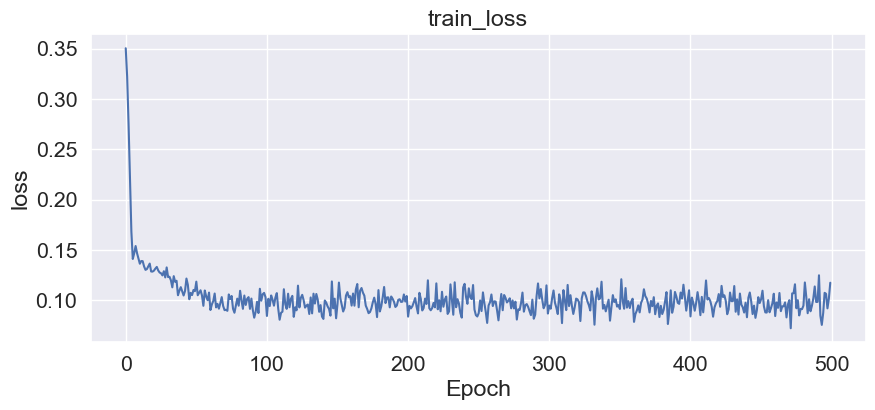

In [9]:
# create the MLP and CNN models
mlp = models.create_mlp((2), regress=False)# input shape -> (2,)
#mlp.summary()
cnn = models.create_cnn(64, 48, 3, regress=False)
#cnn.summary()

# create the input to our final set of layers as the *output* of both the MLP and CNN
combinedInput = concatenate([mlp.output, cnn.output])

# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Embedding(output_dim=50, input_dim=100, input_length=100)(combinedInput)
x = LSTM(64)(x)
x = Dense(4, activation="relu")(x)
x = Dense(1, activation="linear")(x)

model = Model(inputs=[mlp.input, cnn.input], outputs=x)
model.summary()

opt = Adam(lr=1e-3)
model.compile(loss="mse", optimizer=opt, metrics=['accuracy'])

# train the model
print("[INFO] training model...")
history = model.fit([train_X, train_images], train_Y,epochs=500, batch_size=32)  

plt.figure(figsize=(10,4))
plt.title('train_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.plot(history.history["loss"])
plt.show()

## Testing prediction model

3/3 [==============================] - 1s 11ms/step


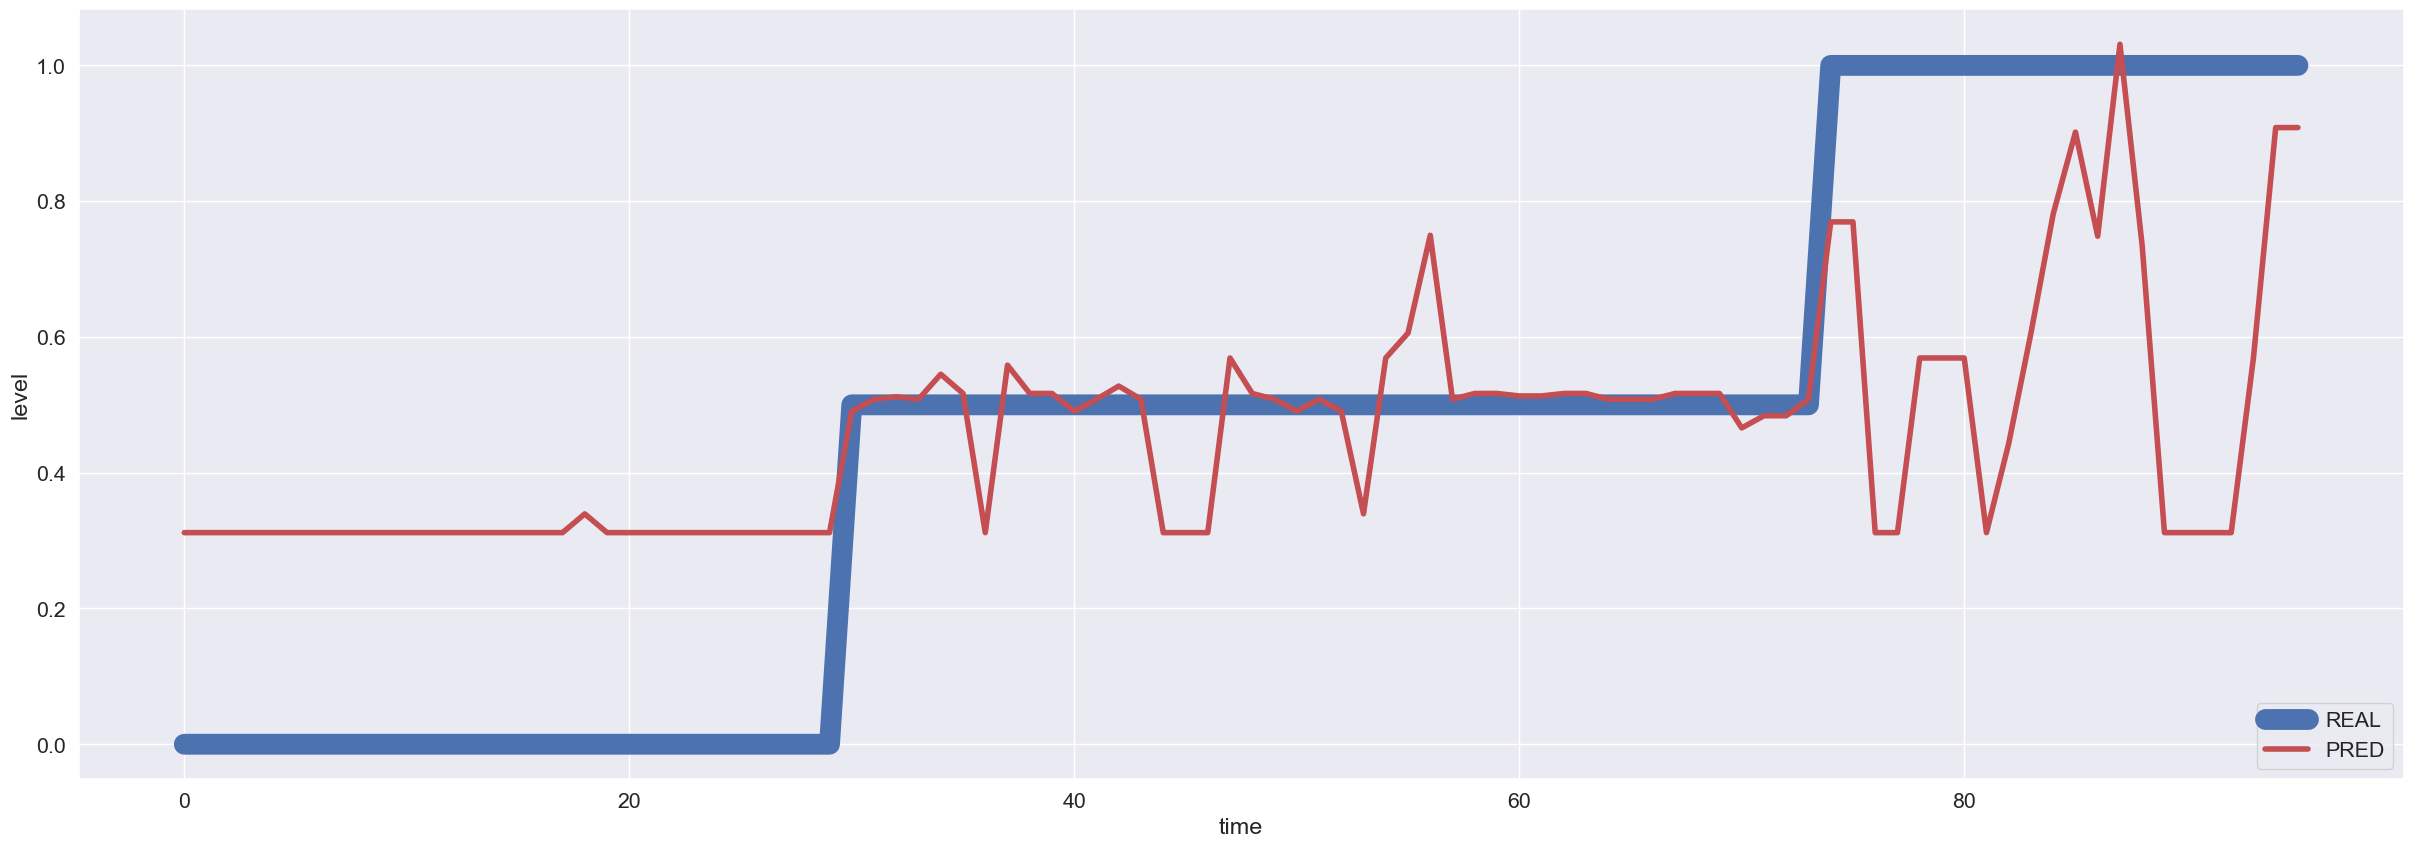

In [9]:
# 畫訓練資料趨勢圖
tPredict = model.predict([train_X, train_images])

look_back = 0
# shift train predictions for plotting
tPredictPlot = np.empty_like(train_Y)
tPredictPlot[:, :] = np.nan
tPredictPlot[look_back:len(tPredict)+look_back, :] = tPredict


# 畫原始資料趨勢圖
# plot baseline and predictions
plt.figure(figsize=(30,10))
plt.plot(train_Y,'b', linewidth=15.0)
plt.plot(tPredictPlot,'r', linewidth=4.0)
plt.ylabel('level')
plt.xlabel('time')
plt.legend(['REAL','PRED'], loc = 'lower right')
plt.show()

## Convert model

- Save keras model to tensorflow model file
- Convert tensorflow model file to tensorflow lite model file

In [10]:
#save mlp model to .h5 file
mlp.save('../model/mlp.h5')
cnn.save('../model/cnn.h5')
model.save('../model/model.h5')

/Users/lixuanhao/Library/Python/3.10/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
#Save model
tf.saved_model.save(model, "../model/")

INFO:tensorflow:Assets written to: ../model/assets


INFO:tensorflow:Assets written to: ../model/assets


In [13]:
#Convert the model.
converter = tf.lite.TFLiteConverter.from_saved_model('../model/' , save_format="tf", signatures=concrete_func)#concrete_func = model.signatures[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()


# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

ConverterError: <unknown>:0: error: loc(callsite(callsite(callsite(fused["TensorListReserve:", "TensorArrayV2_1@__inference_standard_lstm_6848"] at fused["PartitionedCall:", "model_1/lstm/PartitionedCall@__inference__wrapped_model_7134"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_10382"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): 'tf.TensorListReserve' op requires element_shape to be static during TF Lite transformation pass
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
<unknown>:0: error: loc(callsite(callsite(callsite(fused["TensorListReserve:", "TensorArrayV2_1@__inference_standard_lstm_6848"] at fused["PartitionedCall:", "model_1/lstm/PartitionedCall@__inference__wrapped_model_7134"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_10382"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): failed to legalize operation 'tf.TensorListReserve' that was explicitly marked illegal
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
<unknown>:0: error: Lowering tensor list ops is failed. Please consider using Select TF ops and disabling `_experimental_lower_tensor_list_ops` flag in the TFLite converter object. For example, converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]\n converter._experimental_lower_tensor_list_ops = False


In [ ]:
# 畫訓練資料趨勢圖
APredict = model.predict([A_X, A_images])

look_back = 0
# shift train predictions for plotting
APredictPlot = np.empty_like(A_Y)
APredictPlot[:, :] = np.nan
APredictPlot[look_back:len(APredict)+look_back, :] = APredict


# 畫原始資料趨勢圖
# plot baseline and predictions
plt.figure(figsize=(30,10))
plt.plot(A_Y,'b', linewidth=15.0)
plt.plot(APredictPlot,'r', linewidth=4.0)
plt.ylabel('level')
plt.xlabel('time')
plt.legend(['REAL','PRED'], loc = 'lower right')
plt.show()

In [ ]:
# 畫訓練資料趨勢圖
BPredict = model.predict([B_X, B_images])

look_back = 0
# shift train predictions for plotting
BPredictPlot = np.empty_like(B_Y)
BPredictPlot[:, :] = np.nan
BPredictPlot[look_back:len(APredict)+look_back, :] = BPredict



# 畫原始資料趨勢圖
# plot baseline and predictions
plt.figure(figsize=(30,10))
plt.plot(B_Y,'b', linewidth=15.0)
plt.plot(BPredictPlot,'r', linewidth=4.0)
plt.ylabel('level')
plt.xlabel('time')
plt.legend(['REAL','PRED'], loc = 'lower right')
plt.show()

In [53]:
import numpy as np
import os
import cv2
import time
import socket

array_of_img = []

def read_directory(directory_name):
    # this loop is for read each image in this foder,directory_name is the foder name with images.
    for filename in os.listdir(r"./"+directory_name):
        #print(filename) #just for test
        #img is used to store the image data 
        color_image = cv2.imread(directory_name + "/" + filename)
        array_of_img.append(color_image)
        #print(img)
        print(filename)
        print(array_of_img)
        
        
        #color_image = cv2.imread('testPlant_A_0~0/level0/plant.jpg')
        #cv2.imwrite("color.jpg",color_image)
        print("shape of color image:{0}".format(color_image.shape))  
        
        """Find Green"""
        hsv = cv2.cvtColor(color_image,cv2.COLOR_BGR2HSV)
        lower_green = np.array([35,43,46])
        upper_green = np.array([77,255,255])
        lower_yellow = np.array([26,43,46])
        upper_yellow = np.array([46,255,255])
        mask_g = cv2.inRange(hsv, lower_green, upper_green)
        mask_y = cv2.inRange(hsv, lower_yellow, upper_yellow)
        mask = cv2.bitwise_or(mask_g,mask_y)
        res = cv2.bitwise_and(color_image,color_image,mask=mask)
        """cv2.imshow('res',res)
        cv2.waitKey(0)
        cv2.destroyAllWindows()"""
        """end"""

        """findContours"""
        gray = cv2.cvtColor(res,cv2.COLOR_BGR2GRAY)
        cnts, _ = cv2.findContours(gray.copy(),cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        clone = color_image.copy()

        area = []
        for k in range(len(cnts)):
            area.append(cv2.contourArea(cnts[k]))
        max_idx = np.argmax(np.array(area))
        cv2.drawContours(clone, cnts, max_idx, (196, 255, 255), 2)
        '''cv2.imshow('res',clone)
        cv2.waitKey(0)
        cv2.destroyAllWindows()'''
        clone1 = color_image.copy()
        #clone1 = cv2.bitwise_and(clone1,color_image,mask=mask)
        x,y,w,h = cv2.boundingRect(cnts[max_idx])
        cv2.rectangle(clone1,(x,y),(x+w,y+h),(200,200,0), 2 )

        minn = 0
        maxx = 0
        u=0
        j=0

        '''cv2.imshow('res',clone1)
        cv2.waitKey(0)
        cv2.destroyAllWindows()'''
        print('ok')
        
        img_name = "../data/testPlant_A_0~0/level0_G/" + filename  + ".jpg"
        cv2.imwrite(img_name, clone1)
        
        print('ok')

read_directory("testPlant_A_0~0/level0")

Level1_2021-10-1@6_59_00.jpg
[array([[[123, 132, 170],
        [122, 131, 169],
        [119, 130, 168],
        ...,
        [237, 238, 234],
        [237, 238, 234],
        [237, 238, 234]],

       [[120, 129, 167],
        [120, 129, 167],
        [117, 128, 166],
        ...,
        [237, 238, 234],
        [237, 238, 234],
        [237, 238, 234]],

       [[118, 129, 167],
        [117, 128, 166],
        [117, 128, 166],
        ...,
        [237, 238, 234],
        [237, 238, 234],
        [237, 238, 234]],

       ...,

       [[145, 157, 157],
        [145, 157, 157],
        [145, 157, 157],
        ...,
        [192, 176, 147],
        [193, 177, 148],
        [194, 178, 149]],

       [[145, 157, 157],
        [145, 157, 157],
        [145, 157, 157],
        ...,
        [195, 177, 148],
        [195, 177, 148],
        [195, 177, 148]],

       [[146, 158, 158],
        [146, 158, 158],
        [146, 158, 158],
        ...,
        [196, 178, 149],
        [196, 178, 

Level1_2021-9-27@13_59_00.jpg
[array([[[123, 132, 170],
        [122, 131, 169],
        [119, 130, 168],
        ...,
        [237, 238, 234],
        [237, 238, 234],
        [237, 238, 234]],

       [[120, 129, 167],
        [120, 129, 167],
        [117, 128, 166],
        ...,
        [237, 238, 234],
        [237, 238, 234],
        [237, 238, 234]],

       [[118, 129, 167],
        [117, 128, 166],
        [117, 128, 166],
        ...,
        [237, 238, 234],
        [237, 238, 234],
        [237, 238, 234]],

       ...,

       [[145, 157, 157],
        [145, 157, 157],
        [145, 157, 157],
        ...,
        [192, 176, 147],
        [193, 177, 148],
        [194, 178, 149]],

       [[145, 157, 157],
        [145, 157, 157],
        [145, 157, 157],
        ...,
        [195, 177, 148],
        [195, 177, 148],
        [195, 177, 148]],

       [[146, 158, 158],
        [146, 158, 158],
        [146, 158, 158],
        ...,
        [196, 178, 149],
        [196, 178,

        [208, 201, 174]]], dtype=uint8)]
shape of color image:(480, 640, 3)
ok
ok
Level1_2021-9-27@9_5_00.jpg
[array([[[123, 132, 170],
        [122, 131, 169],
        [119, 130, 168],
        ...,
        [237, 238, 234],
        [237, 238, 234],
        [237, 238, 234]],

       [[120, 129, 167],
        [120, 129, 167],
        [117, 128, 166],
        ...,
        [237, 238, 234],
        [237, 238, 234],
        [237, 238, 234]],

       [[118, 129, 167],
        [117, 128, 166],
        [117, 128, 166],
        ...,
        [237, 238, 234],
        [237, 238, 234],
        [237, 238, 234]],

       ...,

       [[145, 157, 157],
        [145, 157, 157],
        [145, 157, 157],
        ...,
        [192, 176, 147],
        [193, 177, 148],
        [194, 178, 149]],

       [[145, 157, 157],
        [145, 157, 157],
        [145, 157, 157],
        ...,
        [195, 177, 148],
        [195, 177, 148],
        [195, 177, 148]],

       [[146, 158, 158],
        [146, 158, 158],
 

        [224, 219, 174]]], dtype=uint8)]
shape of color image:(480, 640, 3)
ok
ok
Level1_2021-9-28@15_59_00.jpg
[array([[[123, 132, 170],
        [122, 131, 169],
        [119, 130, 168],
        ...,
        [237, 238, 234],
        [237, 238, 234],
        [237, 238, 234]],

       [[120, 129, 167],
        [120, 129, 167],
        [117, 128, 166],
        ...,
        [237, 238, 234],
        [237, 238, 234],
        [237, 238, 234]],

       [[118, 129, 167],
        [117, 128, 166],
        [117, 128, 166],
        ...,
        [237, 238, 234],
        [237, 238, 234],
        [237, 238, 234]],

       ...,

       [[145, 157, 157],
        [145, 157, 157],
        [145, 157, 157],
        ...,
        [192, 176, 147],
        [193, 177, 148],
        [194, 178, 149]],

       [[145, 157, 157],
        [145, 157, 157],
        [145, 157, 157],
        ...,
        [195, 177, 148],
        [195, 177, 148],
        [195, 177, 148]],

       [[146, 158, 158],
        [146, 158, 158],

[array([[[123, 132, 170],
        [122, 131, 169],
        [119, 130, 168],
        ...,
        [237, 238, 234],
        [237, 238, 234],
        [237, 238, 234]],

       [[120, 129, 167],
        [120, 129, 167],
        [117, 128, 166],
        ...,
        [237, 238, 234],
        [237, 238, 234],
        [237, 238, 234]],

       [[118, 129, 167],
        [117, 128, 166],
        [117, 128, 166],
        ...,
        [237, 238, 234],
        [237, 238, 234],
        [237, 238, 234]],

       ...,

       [[145, 157, 157],
        [145, 157, 157],
        [145, 157, 157],
        ...,
        [192, 176, 147],
        [193, 177, 148],
        [194, 178, 149]],

       [[145, 157, 157],
        [145, 157, 157],
        [145, 157, 157],
        ...,
        [195, 177, 148],
        [195, 177, 148],
        [195, 177, 148]],

       [[146, 158, 158],
        [146, 158, 158],
        [146, 158, 158],
        ...,
        [196, 178, 149],
        [196, 178, 149],
        [196, 178, 149]

Level1_2021-9-29@6_59_00.jpg
[array([[[123, 132, 170],
        [122, 131, 169],
        [119, 130, 168],
        ...,
        [237, 238, 234],
        [237, 238, 234],
        [237, 238, 234]],

       [[120, 129, 167],
        [120, 129, 167],
        [117, 128, 166],
        ...,
        [237, 238, 234],
        [237, 238, 234],
        [237, 238, 234]],

       [[118, 129, 167],
        [117, 128, 166],
        [117, 128, 166],
        ...,
        [237, 238, 234],
        [237, 238, 234],
        [237, 238, 234]],

       ...,

       [[145, 157, 157],
        [145, 157, 157],
        [145, 157, 157],
        ...,
        [192, 176, 147],
        [193, 177, 148],
        [194, 178, 149]],

       [[145, 157, 157],
        [145, 157, 157],
        [145, 157, 157],
        ...,
        [195, 177, 148],
        [195, 177, 148],
        [195, 177, 148]],

       [[146, 158, 158],
        [146, 158, 158],
        [146, 158, 158],
        ...,
        [196, 178, 149],
        [196, 178, 

        [236, 228, 198]]], dtype=uint8)]
shape of color image:(480, 640, 3)
ok
ok
Level1_2021-9-30@11_59_00.jpg
[array([[[123, 132, 170],
        [122, 131, 169],
        [119, 130, 168],
        ...,
        [237, 238, 234],
        [237, 238, 234],
        [237, 238, 234]],

       [[120, 129, 167],
        [120, 129, 167],
        [117, 128, 166],
        ...,
        [237, 238, 234],
        [237, 238, 234],
        [237, 238, 234]],

       [[118, 129, 167],
        [117, 128, 166],
        [117, 128, 166],
        ...,
        [237, 238, 234],
        [237, 238, 234],
        [237, 238, 234]],

       ...,

       [[145, 157, 157],
        [145, 157, 157],
        [145, 157, 157],
        ...,
        [192, 176, 147],
        [193, 177, 148],
        [194, 178, 149]],

       [[145, 157, 157],
        [145, 157, 157],
        [145, 157, 157],
        ...,
        [195, 177, 148],
        [195, 177, 148],
        [195, 177, 148]],

       [[146, 158, 158],
        [146, 158, 158],

shape of color image:(480, 640, 3)
ok
ok
Level1_2021-9-30@15_3_00.jpg
[array([[[123, 132, 170],
        [122, 131, 169],
        [119, 130, 168],
        ...,
        [237, 238, 234],
        [237, 238, 234],
        [237, 238, 234]],

       [[120, 129, 167],
        [120, 129, 167],
        [117, 128, 166],
        ...,
        [237, 238, 234],
        [237, 238, 234],
        [237, 238, 234]],

       [[118, 129, 167],
        [117, 128, 166],
        [117, 128, 166],
        ...,
        [237, 238, 234],
        [237, 238, 234],
        [237, 238, 234]],

       ...,

       [[145, 157, 157],
        [145, 157, 157],
        [145, 157, 157],
        ...,
        [192, 176, 147],
        [193, 177, 148],
        [194, 178, 149]],

       [[145, 157, 157],
        [145, 157, 157],
        [145, 157, 157],
        ...,
        [195, 177, 148],
        [195, 177, 148],
        [195, 177, 148]],

       [[146, 158, 158],
        [146, 158, 158],
        [146, 158, 158],
        ...,
   

Level1_2021-9-30@7_59_00.jpg
[array([[[123, 132, 170],
        [122, 131, 169],
        [119, 130, 168],
        ...,
        [237, 238, 234],
        [237, 238, 234],
        [237, 238, 234]],

       [[120, 129, 167],
        [120, 129, 167],
        [117, 128, 166],
        ...,
        [237, 238, 234],
        [237, 238, 234],
        [237, 238, 234]],

       [[118, 129, 167],
        [117, 128, 166],
        [117, 128, 166],
        ...,
        [237, 238, 234],
        [237, 238, 234],
        [237, 238, 234]],

       ...,

       [[145, 157, 157],
        [145, 157, 157],
        [145, 157, 157],
        ...,
        [192, 176, 147],
        [193, 177, 148],
        [194, 178, 149]],

       [[145, 157, 157],
        [145, 157, 157],
        [145, 157, 157],
        ...,
        [195, 177, 148],
        [195, 177, 148],
        [195, 177, 148]],

       [[146, 158, 158],
        [146, 158, 158],
        [146, 158, 158],
        ...,
        [196, 178, 149],
        [196, 178, 

In [1]:
#import pyrealsense2.pyrealsense2 as rs
import numpy as np
import cv2
import time
import socket

color_image = cv2.imread('plant1.jpg')
#cv2.imwrite("color.jpg",color_image)
print("shape of color image:{0}".format(color_image.shape))
"""Find Green"""
hsv = cv2.cvtColor(color_image,cv2.COLOR_BGR2HSV)
lower_green = np.array([35,43,46])
upper_green = np.array([77,255,255])
lower_yellow = np.array([26,43,46])
upper_yellow = np.array([46,255,255])
mask_g = cv2.inRange(hsv, lower_green, upper_green)
mask_y = cv2.inRange(hsv, lower_yellow, upper_yellow)
mask = cv2.bitwise_or(mask_g,mask_y)
res = cv2.bitwise_and(color_image,color_image,mask=mask)
"""cv2.imshow('res',res)
cv2.waitKey(0)
cv2.destroyAllWindows()"""
"""end"""

"""findContours"""
gray = cv2.cvtColor(res,cv2.COLOR_BGR2GRAY)
cnts, _ = cv2.findContours(gray.copy(),cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
clone = color_image.copy()

area = []
for k in range(len(cnts)):
    area.append(cv2.contourArea(cnts[k]))
max_idx = np.argmax(np.array(area))

clone1 = color_image.copy()
#clone1 = cv2.bitwise_and(clone1,color_image,mask=mask)
x,y,w,h = cv2.boundingRect(cnts[max_idx])
cv2.rectangle(clone1,(x,y),(x+w,y+h),(200,200,0), 2 )

minn = 0
maxx = 0
u=0
j=0

cv2.imshow('res',clone1)
cv2.waitKey(0)
cv2.destroyAllWindows()
print('ok')

shape of color image:(480, 640, 3)
ok
